In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from collections import Counter
import squidpy as sq
from scipy.spatial.distance import pdist, squareform
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import tabulate
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
from tabulate import tabulate
import umap
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
import gget

# locals
import utils as ut
reload(ut)

2022-12-01 13:53:14.336719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 13:53:14.470109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-12-01 13:53:14.470134: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-01 13:53:14.495511: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-01 13:53:15.3398

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
clusterPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/clusters.csv"
cf = pd.read_parquet(clusterPath)
print(cf.shape)
print(cf['cellType'].unique())
cf.head()

(427882, 7)
['Macrophages' 'B cells' 'Monocytes' 'NK cells' 'Dendritic cells'
 'T cells' 'Stromal cells']


,gene,scores,pvals,logfoldchanges,clusterId,key,cellType
0,H2-EB1,36.343353,4.575346e-181,3.564091,1,ND,Macrophages
1,H2-AA,35.311523,4.761517e-183,3.430534,1,ND,Macrophages
2,H2-AB1,34.411163,2.815112e-177,3.234597,1,ND,Macrophages
3,CD74,33.910587,2.451588e-177,3.302062,1,ND,Macrophages
4,H2-DMA,31.695400,2.991793e-123,2.667091,1,ND,Macrophages


In [3]:
# load gene lists 
pandPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"        
pandf = ut.read_panglaodb(pandPath)

controlList = [
    'Adipocytes',
    'B cells', 
    'Dendritic cells',
    'Macrophages',
    'Monocytes', 
    'NK cells',
    'T cells', 
]

allMarkers = pandf[pandf['cell type'].isin(controlList)]
"""
Ubiquitousness Index (0-1). 
0 indicates the gene is not expressed in any cell cluster and 
1 (maximum) indicates that the gene is expressed in all cell clusters. 
"""

mfList = []

for ctype in controlList:
    markerGenes = allMarkers[allMarkers['cell type'] == ctype]
    
    markerGenes = markerGenes.sort_values(by='ubiquitousness index',
                        ascending=True)
    
    mfList.append(markerGenes[['cell type', 'gene']])


markerGenes = pd.concat(mfList, ignore_index=True)
# take only markers for a specific cell type
markerGenes['cellTypeCount'] = markerGenes.groupby('gene')['cell type'].transform('nunique')
markerGenes = markerGenes[markerGenes['cellTypeCount'] < 2]
markerGenes['cell type'].value_counts()

Adipocytes         110
B cells             85
Macrophages         85
Dendritic cells     72
T cells             67
NK cells            57
Monocytes           56
Name: cell type, dtype: int64

In [4]:
"""load scRNA"""
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

rna = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        rna[key] = data
    
print("done")

done


In [5]:
""" Hand defined by Dr. Muir"""

valGenes = {
    'NK cells' : ["Gzma", "Klrb1a", "Klrb1c", "Spry2"], 
    'B cells' : ["Cd19", "Ms4a1", "Cd22", "CD79a", "CD79b" , "Pax5"], 
    'T cells'  : ["Cd3e"], 
    'Dendritic cells' : ["Clec9a", "Itgae", "Cd24a", "Irf8", "Zbtb46"], 
    'Monocytes' : ["Ms4a4c", "Hp", "Chil3"], 
    'Macrophages' : ["Fcgr1", "Adgre1"],
}

for k, v in valGenes.items():
    vUpper = [x.upper() for x in v]
    valGenes[k] = vUpper
    
valGenes

{'NK cells': ['GZMA', 'KLRB1A', 'KLRB1C', 'SPRY2'],
 'B cells': ['CD19', 'MS4A1', 'CD22', 'CD79A', 'CD79B', 'PAX5'],
 'T cells': ['CD3E'],
 'Dendritic cells': ['CLEC9A', 'ITGAE', 'CD24A', 'IRF8', 'ZBTB46'],
 'Monocytes': ['MS4A4C', 'HP', 'CHIL3'],
 'Macrophages': ['FCGR1', 'ADGRE1']}

In [6]:
"""Compute the overlap between the validation genes and pangloa markers """

res = []

for ctype, valGene in valGenes.items():
    nVal = len(valGene)
    pGenes = markerGenes[markerGenes['cell type'] == ctype]['gene'].to_list()
    nPGene = len(pGenes)    
    nCommon = np.sum([1 for x in valGene if x in pGenes])
    
    row = {
        'Cell Type' : ctype,
        'nMarker' : nVal,
        'nPGDB' : nPGene,
        'nShared' : nCommon,
        'percShared' : nCommon/nVal
    }
    
    res.append(row)
    
res = pd.DataFrame(res)
print(tabulate(res, headers=res.columns, tablefmt='latex', showindex=False))

\begin{tabular}{lrrrr}
\hline
 Cell Type       &   nMarker &   nPGDB &   nShared &   percShared \\
\hline
 NK cells        &         4 &      57 &         2 &     0.5      \\
 B cells         &         6 &      85 &         4 &     0.666667 \\
 T cells         &         1 &      67 &         0 &     0        \\
 Dendritic cells &         5 &      72 &         4 &     0.8      \\
 Monocytes       &         3 &      56 &         0 &     0        \\
 Macrophages     &         2 &      85 &         1 &     0.5      \\
\hline
\end{tabular}


In [7]:

keys = ['ND']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3

for key in keys:
    data = rna[key]
    df = data.to_df()
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    print(key, runKey)
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    
    
    for ctype, valGene in valGenes.items():

        # get the cell type cluster Ids
        mask = (cf['cellType'] == ctype) & (cf['key'] == key)
        cids = cf[mask]['clusterId'].unique()
        
        mask = clusterIds.isin(cids)
        color = np.where(mask, ctype, 'Other Cells')
        
        # get expression
        exp = df[valGene]
        
            
        # print non zero expression
        r = pd.DataFrame(exp.astype(bool).sum(axis=0)).reset_index(drop=False)
        r.columns = ['gene', 'nz_count']
        r['percTotal'] = r['nz_count'] / len(exp)
        r['percCellType'] = r['nz_count'] / np.sum(mask)
        print(f'\n==== {ctype} ==== ({np.sum(mask)})\n', r)
            
        exp = exp.reset_index(drop=False)
            
#         exp['color'] = color
        
#         exp = pd.melt(exp, id_vars=['index', 'color'], value_vars=valGene)
        
#         exp['variable'] = exp['variable'].apply(lambda x: str(x).lower().capitalize())
#         exp['value'] = exp['value'].fillna(0)
         
        
#         sns.boxplot(data=exp,
#                     x='variable', 
#                     y='value',
#                     hue='color', 
#                     palette=['indianred', 'grey'],
#                     hue_order=[ctype, 'Other Cells'],
#                     showfliers=False)
        
#         plt.xlabel(f"{ctype} Marker Genes")
#         plt.title(key)
#         plt.ylabel(f"Expression")
#         plt.gca().legend().set_title('')
#         plt.legend(loc='upper right')
#         plt.show()

ND nn9_pca50_r0.95

==== NK cells ==== (96)
      gene  nz_count  percTotal  percCellType
0    GZMA        55   0.043616      0.572917
1  KLRB1A        38   0.030135      0.395833
2  KLRB1C        50   0.039651      0.520833
3   SPRY2        33   0.026170      0.343750

==== B cells ==== (362)
     gene  nz_count  percTotal  percCellType
0   CD19       148   0.117367      0.408840
1  MS4A1       219   0.173672      0.604972
2   CD22       118   0.093577      0.325967
3  CD79A       306   0.242665      0.845304
4  CD79B       338   0.268041      0.933702
5   PAX5       130   0.103093      0.359116

==== T cells ==== (93)
    gene  nz_count  percTotal  percCellType
0  CD3E       163   0.129262      1.752688

==== Dendritic cells ==== (143)
      gene  nz_count  percTotal  percCellType
0  CLEC9A       168   0.133228      1.174825
1   ITGAE        58   0.045995      0.405594
2   CD24A       523   0.414750      3.657343
3    IRF8       515   0.408406      3.601399
4  ZBTB46       185   0.14

In [8]:
""" what are the marker genes for monocytes? """

keys = ['ND']
alpha = 0.05
lftRange = np.linspace(0, 3, 10)
clusterPropRange = [0.8]
# clusterPropRange = np.linspace(0.1, 0.9, 10)

res = []

for lft in lftRange:
    for clusterProp in clusterPropRange:
        for key in keys:
            ctdf = cf[cf['key'] == key].reset_index(drop=True)

            # simple filters
            ctdf = ctdf[ctdf['logfoldchanges'] >= lft]
            ctdf = ctdf[ctdf['pvals'] <= alpha].reset_index(drop=True)

            # extract cell types of interest
            mono = ctdf[ctdf['cellType'] == 'Monocytes'].reset_index(drop=True)
            macro = ctdf[ctdf['cellType'] == 'Macrophages'].reset_index(drop=True)

            # compute "cluster coverage"
            mono['nCluster'] = mono.groupby('gene')['clusterId'].transform('nunique')
            macro['nCluster'] = macro.groupby('gene')['clusterId'].transform('nunique')

            mono['totalCluster'] = mono['clusterId'].nunique()
            macro['totalCluster'] = macro['clusterId'].nunique()

            # filter out genes expressed in less than propCluster * totalCluster of clusters
            mask = (mono['nCluster'] >= (mono['totalCluster'] * clusterProp))
            mono = mono[mask].reset_index(drop=True)

            mask = (macro['nCluster'] >= (macro['totalCluster'] * clusterProp))
            macro = macro[mask].reset_index(drop=True)

            # get the genes from each
            moGenes = mono['gene'].to_list()
            maGenes = macro['gene'].to_list()

            intersectAll = set(moGenes).intersection(set(maGenes))
            monoOnly = np.setdiff1d(moGenes, maGenes)
            macroOnly = np.setdiff1d(maGenes, moGenes)
            
            row = {
                'LFC_threshold' : lft,
                'PropCluster_threshold' : clusterProp,
                'nMacrophageGenes' : len(maGenes),
                'nMonocyteGenes' : len(moGenes),
                'nIntersect' : len(intersectAll),
                'nMonoOnly' : len(monoOnly),
                'nMacroOnly' : len(macroOnly),
                'MacrophageGenes' : maGenes,
                'MonocyteGenes' : moGenes,
                'intersection' : intersectAll,
                'MonoOnly' : monoOnly,
                'MacroOnly' : macroOnly,
            }
            
            res.append(row)
            

res = pd.DataFrame(res)
res[['LFC_threshold', 'PropCluster_threshold', 'nMacrophageGenes', 'nMonocyteGenes', 'nIntersect']].head()

,LFC_threshold,PropCluster_threshold,nMacrophageGenes,nMonocyteGenes,nIntersect
0,0.000000,0.8,92,66,0
1,0.333333,0.8,88,66,0
2,0.666667,0.8,52,54,0
3,1.000000,0.8,24,27,0
4,1.333333,0.8,12,18,0


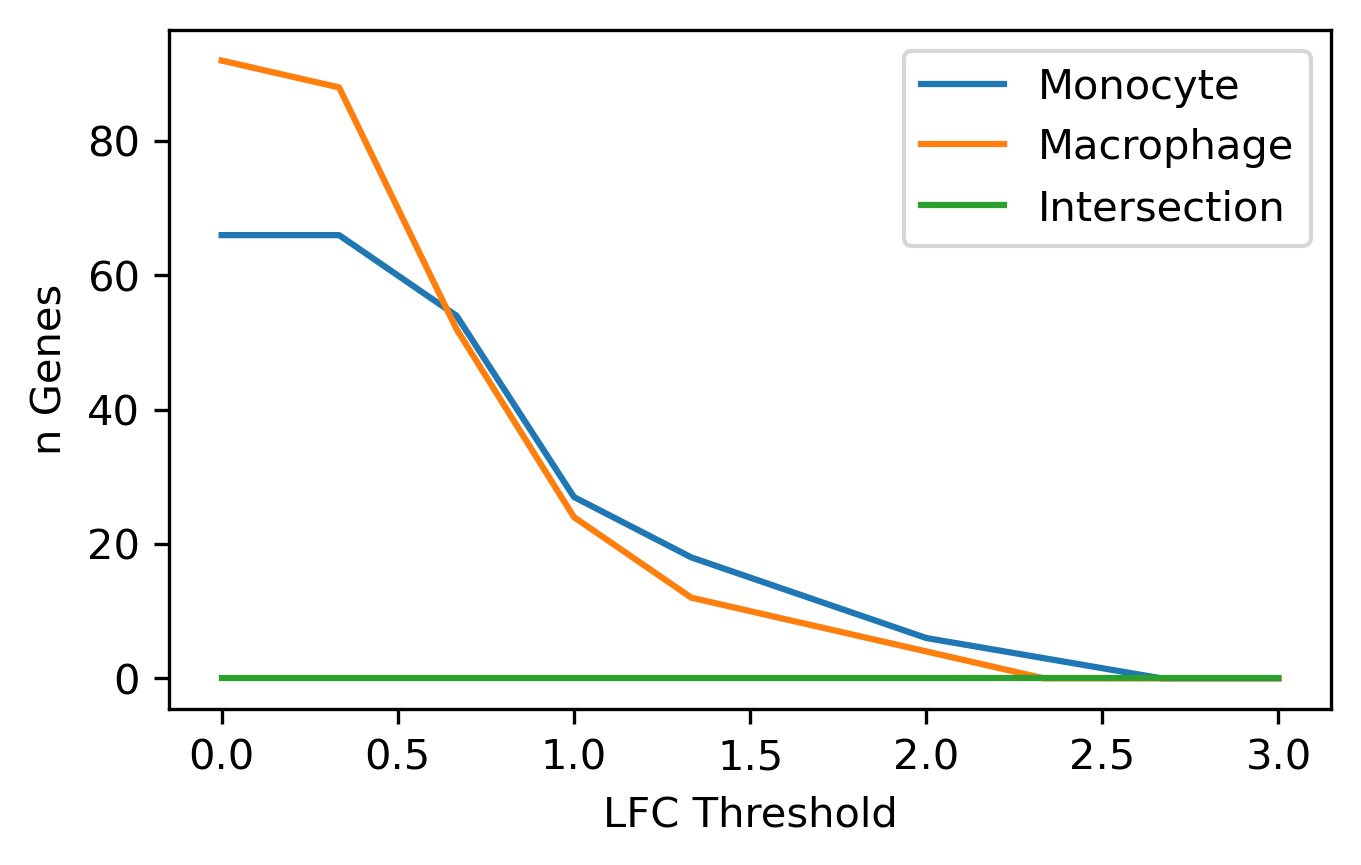

In [9]:
x = 'LFC_threshold'
y = 'nMonocyteGenes'
pltDf = res.drop_duplicates(subset=[x, y])
plt.plot(pltDf[x], 
         pltDf[y], 
         label='Monocyte')

x = 'LFC_threshold'
y = 'nMacrophageGenes'
pltDf = res.drop_duplicates(subset=[x, y])
plt.plot(pltDf[x], 
         pltDf[y], 
         label='Macrophage')

x = 'LFC_threshold'
y = 'nIntersect'
pltDf = res.drop_duplicates(subset=[x, y])
plt.plot(pltDf[x], 
         pltDf[y], 
         label='Intersection')

plt.xlabel('LFC Threshold')
plt.ylabel('n Genes')

plt.legend()

In [10]:
ltf = 1

rf = res[res['LFC_threshold'] >= ltf].reset_index(drop=True)

for idx, row in rf.iterrows():
    
    lf = f"{row['LFC_threshold']:.3f}"
    monoGenes = list(row['MonoOnly'])
    macroGenes = list(row['MacroOnly'])
    
    pgMonoMarker = markerGenes[markerGenes['cell type'] == 'Monocytes']['gene'].to_list()
    pgMacroMarker = markerGenes[markerGenes['cell type'] == 'Macrophages']['gene'].to_list()
    
    nMono = np.sum([1 for x in monoGenes if x in pgMonoMarker])
    nMacro = np.sum([1 for x in macroGenes if x in pgMacroMarker])
    

    print(f"{lf} \n\tMono: {monoGenes} ({nMono}) \n\tMacro: {macroGenes} ({nMacro})")

# rf.head()

1.000 
	Mono: ['CCL6', 'CD300LB', 'EMILIN2', 'FGR', 'GDA', 'LILRB4A', 'NCF2', 'PILRA', 'SLC15A3'] (1) 
	Macro: ['CD68', 'CTSS', 'FCER1G', 'FTH1', 'LY86', 'TYROBP'] (1)
1.333 
	Mono: ['CCL6', 'FGR', 'GDA', 'LILRB4A', 'PILRA', 'SLC15A3'] (1) 
	Macro: ['CTSS', 'FCER1G', 'TYROBP'] (1)
1.667 
	Mono: ['CCL6', 'GDA', 'PILRA', 'SLC15A3'] (1) 
	Macro: ['FCER1G', 'TYROBP'] (1)
2.000 
	Mono: ['GDA', 'PILRA'] (1) 
	Macro: ['FCER1G'] (0.0)
2.333 
	Mono: ['GDA'] (0.0) 
	Macro: [] (0.0)
2.667 
	Mono: [] (0.0) 
	Macro: [] (0.0)
3.000 
	Mono: [] (0.0) 
	Macro: [] (0.0)


In [59]:
""" what are the genes with the highest precision? """

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor'] = "w"

keys = ['ND']
ctypes = ['Monocytes']
runIndividualClusters = True

res = []

for key in keys:
    data = rna[key]
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    print(key, runKey)
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    df = data.to_df()
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
    
    for ctype in ctypes:
        mask = (cf['cellType'] == ctype) & (cf['key'] == key)
        cids = cf[mask]['clusterId'].unique()
        
        # get global mask 
        masks = {'allClusters' : clusterIds.isin(cids)}
        
        if runIndividualClusters:
            for cidx in cids:
                masks[f"cluster_{cidx}"] = clusterIds.isin([cidx])
                
                
        for g in df.columns:
            y_pred = np.where(df[g] > 0, 1, 0)
                
            # get precision of each gene where nonzero expression    
            for cluster, mask in masks.items():
                # get all cells
                cells = df[mask]
                y_true = np.where(mask, 1, 0)
                
                row = {
                    'clusterType' : cluster,
                    'gene' : g,
                    'precision' : metrics.precision_score(y_true, y_pred),
                    'accuracy' : metrics.accuracy_score(y_true, y_pred),
                }
                res.append(row)
            
            
res = pd.DataFrame(res)
print(res.shape)
res.head()

ND nn9_pca50_r0.95
(49960, 4)


,clusterType,gene,precision,accuracy
0,allClusters,MRPL15,0.081871,0.634417
1,cluster_5,MRPL15,0.046784,0.666138
2,cluster_10,MRPL15,0.035088,0.708168
3,cluster_17,MRPL15,0.000000,0.717684
4,allClusters,LYPLA1,0.112840,0.703410


In [60]:

clusterT = 'cluster_10'

bf = res[res['clusterType'] == clusterT].sort_values(by='precision', ascending=False)

n = 100
topGene = bf.head(n)['gene'].to_list()
pGene = markerGenes[markerGenes['cell type'] == 'Monocytes']['gene'].to_list()

print(np.sum([1 for x in topGene if x in pGene]))
print()
bf.head()

4



,clusterType,gene,precision,accuracy
20082,cluster_10,CD177,0.800000,0.969865
36462,cluster_10,CD300E,0.733333,0.965900
9986,cluster_10,CHIL3,0.689655,0.969072
46242,cluster_10,TREM3,0.652174,0.965900
8402,cluster_10,GM5150,0.487805,0.959556
